# A/B Testing on Simulated Data

## Introduction
This project demonstrates how to design, simulate, and analyze a basic A/B test using synthetic data.  
The goal is to showcase the end-to-end workflow of an online experiment, from data generation to statistical analysis, in a fully reproducible way.

The simulated scenario mimics a simple e-commerce experiment where a company tests a new **Call-To-Action (CTA)** button against the current version:

- **Group A (Control):** baseline CTA  
- **Group B (Treatment):** new CTA with an expected uplift in conversions  

Each simulated user is randomly assigned to one of the groups, along with additional heterogeneity:
- **New vs. returning users**: new users are modeled to convert at a slightly lower rate.  
- **Day-to-day variability**: daily noise is added to reflect real-world fluctuations.  

The dataset contains the following columns:
- `user_id`: unique identifier for each user  
- `date`: simulated visit date  
- `group`: experiment assignment (A or B)  
- `is_new_user`: whether the user is new (1) or returning (0)  
- `converted`: binary indicator (1 = converted, 0 = not converted)  
- `revenue`: revenue generated (0 if not converted, >0 if converted)  

The analysis focuses on:
- Estimating **conversion rates** for A vs. B  
- Computing the **uplift** (absolute and relative differences)  
- Reporting key business metrics such as **ARPU (Average Revenue Per User)**  
- Running statistical tests to determine whether differences are significant  

This project is intended as a clear, educational example of how to set up and interpret an A/B test, making it suitable for a data science or analytics portfolio.


## Load libraries and data

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
from scipy import stats

In [2]:
df=pd.read_csv("ab_data_simulated.csv")
display(df.head())

,user_id,group,date,is_new_user,converted,revenue
0,1,A,2025-07-01,0,1,26.122426
1,2,A,2025-07-25,1,0,0.000000
2,3,A,2025-07-04,0,0,0.000000
3,4,A,2025-07-23,0,0,0.000000
4,5,A,2025-07-01,1,0,0.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      40000 non-null  int64  
 1   group        40000 non-null  object 
 2   date         40000 non-null  object 
 3   is_new_user  40000 non-null  int64  
 4   converted    40000 non-null  int64  
 5   revenue      40000 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 1.8+ MB


In [5]:
# Fix dtypes
df = df.astype({
    "user_id": "int32",        # smaller int type is enough
    "group": "category",       # categorical: A/B
    "date": "datetime64[ns]",  # proper datetime
    "is_new_user": "int8",     # binary: 0/1
    "converted": "int8",       # binary: 0/1
    "revenue": "float32"       # continuous, can save memory vs float64
})

# Check results
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      40000 non-null  int32         
 1   group        40000 non-null  category      
 2   date         40000 non-null  datetime64[ns]
 3   is_new_user  40000 non-null  int8          
 4   converted    40000 non-null  int8          
 5   revenue      40000 non-null  float32       
dtypes: category(1), datetime64[ns](1), float32(1), int32(1), int8(2)
memory usage: 742.4 KB


With the dataset successfully loaded and the column data types corrected, we now have a clean and structured foundation for the analysis. Each column is properly formatted — categorical variables are stored efficiently, binary indicators use compact integer types, and dates are recognized as datetime objects. This ensures that subsequent calculations, groupings, and visualizations will run smoothly and accurately, providing a reliable starting point for the A/B test evaluation.


## Exploratory Analysis

Before diving into hypothesis testing, it is important to explore the dataset and understand the underlying distributions. This step helps verify that the experiment was properly randomized and that the two groups are comparable in size and composition. We begin by examining the balance between groups A and B, the proportion of new versus returning users, and the overall time coverage of the experiment. These checks provide confidence that any observed differences in outcomes are due to the treatment rather than imbalances in the data.

In [6]:
# ----------------------------
# Users per group
# ----------------------------
group_counts = df["group"].value_counts(normalize=True) * 100
print("Users per group (%):")
print(group_counts.round(2))
print()


Users per group (%):
group
A    50.0
B    50.0
Name: proportion, dtype: float64



In [7]:
# ----------------------------
# Distribution of new vs returning users across groups
# ----------------------------
user_distribution = pd.crosstab(df["group"], df["is_new_user"], normalize="index") * 100
user_distribution.columns = ["Returning (%)", "New (%)"]
print("New vs Returning users per group (%):")
print(user_distribution.round(2))
print()

New vs Returning users per group (%):
       Returning (%)  New (%)
group                        
A              39.65    60.36
B              39.82    60.18



In [8]:
# ----------------------------
# Date coverage
# ----------------------------
min_date, max_date = df["date"].min(), df["date"].max()
print(f"Date range in data: {min_date} → {max_date}")


Date range in data: 2025-07-01 00:00:00 → 2025-07-30 00:00:00


In [ ]:
# ----------------------------
# Descriptive stats
# ----------------------------

# Conversion rate per group (mean of 0/1 "converted")
conversion_rate = df.groupby("group", observed=True)["converted"].mean() * 100  # observed = True to avoid warning 

# ARPU (Average Revenue Per User) = mean of revenue (includes zeros)
arpu = df.groupby("group", observed=True)["revenue"].mean()

# ARPPU (Average Revenue Per Paying User) = mean of revenue among converters only
arppu = df[df["converted"] == 1].groupby("group", observed=True)["revenue"].mean()

# Combine into one summary table
descriptive_stats = pd.DataFrame({
    "Conversion Rate (%)": conversion_rate.round(2),
    "ARPU": arpu.round(2),
    "ARPPU": arppu.round(2)
})

print("=== Descriptive Statistics by Group ===")
print(descriptive_stats)


=== Descriptive Statistics by Group ===
       Conversion Rate (%)  ARPU      ARPPU
group                                      
A                     2.78  1.55  55.599998
B                     3.63  2.15  59.299999


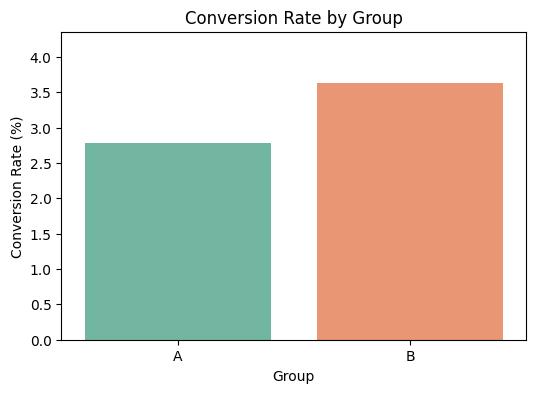

In [15]:
# ----------------------------
# 1. Bar plot: Conversion Rate A vs B
# ----------------------------
conv_rate = df.groupby("group", observed=True)["converted"].mean().reset_index()
conv_rate["converted"] *= 100  # convert to %

plt.figure(figsize=(6,4))
sns.barplot(x="group", y="converted", hue="group",
            data=conv_rate, palette="Set2", legend=False)
plt.title("Conversion Rate by Group")
plt.ylabel("Conversion Rate (%)")
plt.xlabel("Group")
plt.ylim(0, conv_rate["converted"].max() * 1.2)
plt.show()

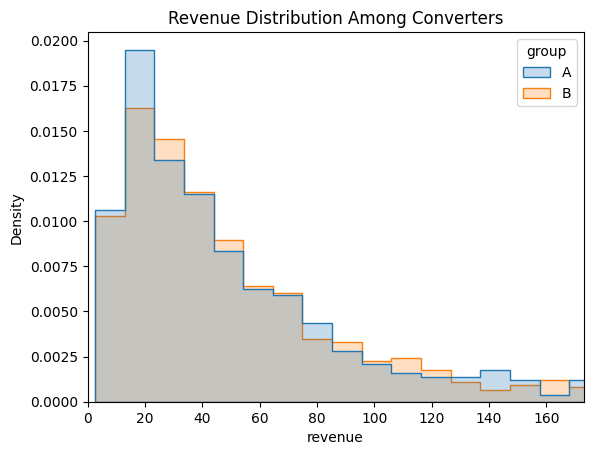

In [20]:
# subset: converters only
conv = df[df["converted"] == 1].copy()

# choose a sensible upper limit from positive revenue only
upper = conv.loc[conv["revenue"] > 0, "revenue"].quantile(0.95)
if np.isfinite(upper) and upper > 0:
    x_max = upper
else:
    x_max = conv["revenue"].max()  # fallback

# histogram of converters' revenue
sns.histplot(
    data=conv,
    x="revenue",
    hue="group",
    element="step",
    stat="density",
    common_norm=False
)
plt.xlim(0, x_max)
plt.title("Revenue Distribution Among Converters")
plt.show()


In [22]:
# Conversion rates
conv_rates = df.groupby("group", observed=True)["converted"].mean()

pA = conv_rates["A"]
pB = conv_rates["B"]

# Uplift calculations
absolute_uplift = pB - pA
relative_uplift = (absolute_uplift / pA) * 100

# Expected additional conversions per 10,000 users
extra_conversions_per_10k = absolute_uplift * 10_000

# ARPU (Average Revenue Per User)
arpu = df.groupby("group", observed=True)["revenue"].mean()

# Incremental revenue per 10,000 users
incremental_revenue = (arpu["B"] - arpu["A"]) * 10_000

# Print results
print(f"Group A conversion rate: {pA*100:.2f}%")
print(f"Group B conversion rate: {pB*100:.2f}%")
print(f"Absolute uplift: {absolute_uplift*100:.2f} p.p.")
print(f"Relative uplift: {relative_uplift:.2f}%")
print(f"Extra conversions per 10k users: {extra_conversions_per_10k:.0f}")
print(f"Incremental revenue per 10k users: ${incremental_revenue:,.2f}")

Group A conversion rate: 2.78%
Group B conversion rate: 3.63%
Absolute uplift: 0.85 p.p.
Relative uplift: 30.58%
Extra conversions per 10k users: 85
Incremental revenue per 10k users: $6,068.17


We confirmed that the two groups were equally distributed in size, and that the proportion of new users as well as the ARPU among converters are roughly the same for both groups, ensuring a balanced experiment. Group A achieved a conversion rate of 2.78%, while Group B reached 3.63%, representing an absolute uplift of +0.85 percentage points and a relative improvement of +30.58%. Translating this effect into business terms, for every 10,000 users exposed to the new CTA (Group B), we would expect approximately 85 additional conversions, corresponding to an incremental revenue of roughly $6.068. These results indicate that the treatment has a meaningful positive impact and making this change available to all users should be considered.

The exploratory analysis confirmed that groups A and B are well balanced in terms of sample size, user composition, and experimental period, ensuring the validity of the comparison. Descriptive statistics provided initial insights into conversion rates, ARPU, and ARPPU, with Group B showing a higher conversion rate than Group A. While these early findings suggest a positive effect of the treatment, statistical testing is required to determine whether the observed differences are statistically significant or could have arisen by chance. We now proceed with formal hypothesis testing.

## Statistical testing

In [24]:
# --- Prepare counts and sample sizes ---
# Ensure 'group' is categorical to avoid future warnings and use observed=True
agg = df.groupby("group", observed=True)["converted"].agg(["sum", "count"])
conv_A, n_A = int(agg.loc["A", "sum"]), int(agg.loc["A", "count"])
conv_B, n_B = int(agg.loc["B", "sum"]), int(agg.loc["B", "count"])

# --- Two-sample Z-test for equality of proportions (H0: pA = pB) ---
# Order matters only for the sign of the z-statistic; two-sided p-value is unaffected.
zstat, pval = proportions_ztest(count=[conv_B, conv_A],
                                nobs=[n_B, n_A],
                                alternative="two-sided")

print(f"\nZ-test for proportions (two-sided):")
print(f"  z-statistic = {zstat:.3f}")
print(f"  p-value     = {pval:.4g}")

# --- 95% Confidence Interval for (pB - pA) ---
# Use Newcombe (score) interval for two independent proportions (generally better than simple Wald).
ci_low, ci_high = confint_proportions_2indep(count1=conv_B, nobs1=n_B,
                                             count2=conv_A, nobs2=n_A,
                                             method="newcomb", compare="diff")

print(f"\n95% CI for (pB - pA): [{ci_low*100:.2f}, {ci_high*100:.2f}] percentage points")



Z-test for proportions (two-sided):
  z-statistic = 4.826
  p-value     = 1.394e-06

95% CI for (pB - pA): [0.51, 1.20] percentage points


The Z-test indicates a statistically significant difference in conversion rates between groups A and B  
(\(z = 4.83, p < 0.001\)). The estimated uplift for Group B is between **0.51 and 1.20 percentage points** at the 95% confidence level. Since the confidence interval does not include zero and the p-value is well below the 0.05 threshold, we can reject the null hypothesis and conclude that the new CTA (Group B) leads to a **real and positive improvement in conversion rate** compared to the control.

From a business perspective, this uplift, though modest in absolute terms, represents a meaningful relative gain given the scale of the user base, and supports moving forward with **broader adoption of the treatment**.


In [26]:
# --- Split data into groups ---
rev_A = df.loc[df["group"] == "A", "revenue"]
rev_B = df.loc[df["group"] == "B", "revenue"]

# --- Descriptive stats ---
mean_A, mean_B = rev_A.mean(), rev_B.mean()
diff = mean_B - mean_A
rr = mean_B / mean_A if mean_A > 0 else np.nan

print(f"ARPU (A): {mean_A:.2f}")
print(f"ARPU (B): {mean_B:.2f}")
print(f"Absolute difference: {diff:.2f}")
print(f"Risk Ratio (B/A): {rr:.3f}")

# --- T-test (parametric) ---
t_stat, p_val_t = stats.ttest_ind(rev_B, rev_A, equal_var=False)  # Welch’s t-test
print("\nT-test (Welch):")
print(f"  t-statistic = {t_stat:.3f}, p-value = {p_val_t:.4g}")

# --- Mann–Whitney U test (non-parametric, robust to skew) ---
u_stat, p_val_u = stats.mannwhitneyu(rev_B, rev_A, alternative="two-sided")
print("\nMann–Whitney U test:")
print(f"  U = {u_stat:.0f}, p-value = {p_val_u:.4g}")


ARPU (A): 1.55
ARPU (B): 2.15
Absolute difference: 0.61
Risk Ratio (B/A): 1.393

T-test (Welch):
  t-statistic = 4.064, p-value = 4.827e-05

Mann–Whitney U test:
  U = 201707138, p-value = 1.265e-06


Both the Welch’s t-test \((t = 4.06, p < 0.001)\) and the Mann–Whitney U test \((p < 0.001)\) indicate that the difference in ARPU between groups A and B is statistically significant. Group A achieved an ARPU of **1.55**, while Group B reached **2.15**, yielding an absolute difference of **+0.61** and a risk ratio of **1.39**. This means that, on average, users in Group B generated nearly **40% more revenue per user** than those in Group A. From a business perspective, this uplift represents a substantial improvement in monetization and strengthens the case for adopting the new CTA across a wider user base.

## Conclusions

The experiment provided strong evidence that the new CTA (Group B) outperforms the control (Group A) on key business metrics.  

- **Conversion Rate:**  
  A Z-test confirmed a statistically significant uplift in conversions for Group B \((z = 4.83, p < 0.001)\). The estimated effect lies between **0.51 and 1.20 percentage points** at the 95% confidence level, demonstrating that the treatment leads to a real and positive improvement in user engagement.  

- **Revenue (ARPU):**  
  Both Welch’s t-test \((t = 4.06, p < 0.001)\) and the Mann–Whitney U test \((p < 0.001)\) indicated that the ARPU difference between groups is statistically significant. Group A achieved an ARPU of **1.55**, while Group B reached **2.15**, representing an absolute increase of **+0.61** and a risk ratio of **1.39**. On average, users in Group B generated nearly **40% more revenue per user** than those in Group A.  

From a business perspective, these results show that the new CTA not only increases the likelihood of conversion but also drives higher revenue per user. Even modest gains at the individual level can translate into substantial financial impact when scaled across the entire user base. The evidence supports moving forward with broader adoption of the treatment.
